In [26]:
!apt-get install default-jre
!java -version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.
openjdk version "11.0.10" 2021-01-19
OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


H20 Runs on java

In [27]:
!pip install requests 
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future
!pip uninstall h2o
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Uninstalling h2o-3.32.0.4:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/h2o-3.32.0.4.dist-info/*
    /usr/local/lib/python3.7/dist-packages/h2o/*
Proceed (y/n)? y
  Successfully uninstalled h2o-3.32.0.4
Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
Processing /root/.cache/pip/wheels/65/f4/0d/c9bb958d70c2e015c968cb91cbd7f1b486933056d422337d75/h2o-3.32.0.4-py2.py3-none-any.whl


In [28]:
import h2o
from h2o.automl import H2OAutoML
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import re
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split

In [29]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 43 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.4
H2O_cluster_version_age:,24 days
H2O_cluster_name:,H2O_from_python_unknownUser_ci4xy5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.138 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [30]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [31]:
df = pd.read_csv('https://github.com/srivatsan88/YouTubeLI/blob/master/dataset/consumer_compliants.zip?raw=true',compression='zip',sep=',',quotechar='"')
df

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,4/3/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Fraudulent loan,This auto loan was opened on XX/XX/2020 in XXX...,Company has responded to the consumer and the ...,TRUIST FINANCIAL CORPORATION,PA,None,None,Consent provided,Web,4/3/2020,Closed with explanation,Yes,NaN,3591341
1,3/12/2020,Debt collection,Payday loan debt,Attempts to collect debt not owed,Debt is not yours,In XXXX of 2019 I noticed a debt for {$620.00}...,None,CURO Intermediate Holdings,CO,806XX,None,Consent provided,Web,3/12/2020,Closed with explanation,Yes,NaN,3564184
2,2/6/2020,Vehicle loan or lease,Loan,Getting a loan or lease,Credit denial,"As stated from Capital One, XXXX XX/XX/XXXX an...",None,CAPITAL ONE FINANCIAL CORPORATION,OH,430XX,None,Consent provided,Web,2/6/2020,Closed with explanation,Yes,NaN,3521949
3,3/6/2020,Checking or savings account,Savings account,Managing an account,Banking errors,"Please see CFPB case XXXX. \n\nCapital One, in...",None,CAPITAL ONE FINANCIAL CORPORATION,CA,None,None,Consent provided,Web,3/6/2020,Closed with explanation,Yes,NaN,3556237
4,2/14/2020,Debt collection,Medical debt,Attempts to collect debt not owed,Debt is not yours,This debt was incurred due to medical malpract...,Company believes it acted appropriately as aut...,"Merchants and Professional Bureau, Inc.",OH,432XX,None,Consent provided,Web,2/14/2020,Closed with explanation,Yes,NaN,3531704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57448,2/29/2020,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Trouble with how payments are being handled,I am attempting to make a payment toward my st...,None,"Nelnet, Inc.",KS,None,None,Consent provided,Web,2/29/2020,Closed with explanation,Yes,NaN,3549178
57449,2/11/2020,Debt collection,Other debt,Attempts to collect debt not owed,Debt was paid,Received letter for {$480.00}. Original credit...,Company has responded to the consumer and the ...,"The Receivable Management Services LLC, New Yo...",AZ,853XX,None,Consent provided,Web,2/18/2020,Closed with explanation,Yes,NaN,3527928
57450,2/29/2020,Debt collection,Other debt,Communication tactics,"Used obscene, profane, or other abusive language",entire time 10 years until XX/XX/2020. XXXX ma...,Company has responded to the consumer and the ...,"Convergent Resources, Inc.",NJ,8101,None,Consent provided,Web,2/29/2020,Closed with explanation,Yes,NaN,3549238
57451,1/16/2020,Checking or savings account,Checking account,Problem with a lender or other company chargin...,Transaction was not authorized,I am a customer with Wells Fargo Bank. Recentl...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,AZ,852XX,None,Consent provided,Web,1/22/2020,Closed with explanation,Yes,NaN,3498566


In [9]:
df['Product'].value_counts()

Debt collection                21772
Credit card or prepaid card    13193
Mortgage                        9799
Checking or savings account     7003
Student loan                    2950
Vehicle loan or lease           2736
Name: Product, dtype: int64

Imbalanced dataset

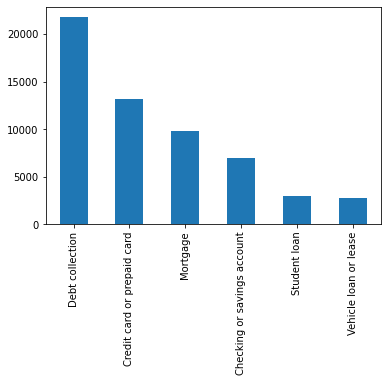

In [10]:
df['Product'].value_counts().plot(kind='bar')

In [11]:
df['Company'].value_counts()

CITIBANK, N.A.                                3226
CAPITAL ONE FINANCIAL CORPORATION             2711
BANK OF AMERICA, NATIONAL ASSOCIATION         2580
JPMORGAN CHASE & CO.                          2409
WELLS FARGO & COMPANY                         2001
                                              ... 
EMG ACQUISITION GROUP, LLC                       1
FACTUAL DATA CORP.                               1
NOVA Financial Holding Company, LLC              1
Paramount Capital Group, Inc.                    1
Commercial Credit Counseling Services Inc.       1
Name: Company, Length: 2197, dtype: int64

In [32]:
complaints_df = df[['Consumer complaint narrative','Product','Company']].rename(columns={'Consumer complaint narrative':'complaints'})
complaints_df

,complaints,Product,Company
0,This auto loan was opened on XX/XX/2020 in XXX...,Vehicle loan or lease,TRUIST FINANCIAL CORPORATION
1,In XXXX of 2019 I noticed a debt for {$620.00}...,Debt collection,CURO Intermediate Holdings
2,"As stated from Capital One, XXXX XX/XX/XXXX an...",Vehicle loan or lease,CAPITAL ONE FINANCIAL CORPORATION
3,"Please see CFPB case XXXX. \n\nCapital One, in...",Checking or savings account,CAPITAL ONE FINANCIAL CORPORATION
4,This debt was incurred due to medical malpract...,Debt collection,"Merchants and Professional Bureau, Inc."
...,...,...,...
57448,I am attempting to make a payment toward my st...,Student loan,"Nelnet, Inc."
57449,Received letter for {$480.00}. Original credit...,Debt collection,"The Receivable Management Services LLC, New Yo..."
57450,entire time 10 years until XX/XX/2020. XXXX ma...,Debt collection,"Convergent Resources, Inc."
57451,I am a customer with Wells Fargo Bank. Recentl...,Checking or savings account,WELLS FARGO & COMPANY


In [33]:
target = {'Debt collection':0, 'Credit card or prepaid card':1, 'Mortgage':2, 'Checking or savings account':3, 'Student loan':4, 'Vehicle loan or lease':5}

In [34]:
complaints_df['target'] = complaints_df['Product'].map(target)

In [35]:
X_train, X_test = train_test_split(complaints_df,test_size=0.2,random_state=111)

In [36]:
#stemmer = PorterStemmer()
stemmer = nltk.stem.SnowballStemmer('english')

In [37]:
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
def tokenize(text):
  tokens = [word for word in nltk.word_tokenize(text) if (len(word)>3 and len(word.strip('Xx/'))>2 and len(re.sub('\d+','',word.strip('Xx/')))>2 )]
  tokens = map(str.lower, tokens)
  stems = [stemmer.stem(item) for item in tokens if (item not in stop_words) ]
  return stems

In [39]:
 vectorizer_tf = TfidfVectorizer(tokenizer=tokenize,stop_words=None, max_df=0.75, max_features=1000, lowercase=False, ngram_range=(1,2))
 train_vectors = vectorizer_tf.fit_transform(X_train.complaints)

In [18]:
train_vectors.A

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05982223, 0.        , ..., 0.        , 0.        ,
        0.04798975],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.09582682],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

For tfidf we want huge vector size to handle it. We can use Dense Vectorizations like word2vec(it understands semmantics of word also)

In [19]:
print(vectorizer_tf.get_feature_names())

['abil', 'abl', 'absolut', 'abus', 'accept', 'access', 'access account', 'accord', 'account', 'account account', 'account balanc', 'account bank', 'account call', 'account close', 'account credit', 'account inform', 'account number', 'account open', 'account report', 'account would', 'accru', 'acct', 'accur', 'acknowledg', 'act', 'action', 'activ', 'actual', 'ad', 'addit', 'address', 'adjust', 'admit', 'advanc', 'advantag', 'advertis', 'advis', 'affect', 'affidavit', 'afford', 'agenc', 'agent', 'agre', 'agreement', 'alert', 'alleg', 'alleg debt', 'alli', 'allow', 'almost', 'along', 'alreadi', 'also', 'although', 'alway', 'america', 'american', 'american express', 'amex', 'amount', 'amount owe', 'and/or', 'annual', 'anoth', 'answer', 'anyon', 'anyth', 'apart', 'appar', 'appeal', 'appear', 'appli', 'applic', 'apprais', 'appreci', 'approv', 'approxim', 'around', 'arrang', 'arriv', 'ask', 'assess', 'asset', 'assign', 'assist', 'associ', 'assum', 'assur', 'attach', 'attempt', 'attempt colle

In [40]:
test_vectors = vectorizer_tf.transform(X_test.complaints)

In [41]:
train_df = pd.DataFrame(train_vectors.toarray(),columns=vectorizer_tf.get_feature_names())
train_df = pd.concat([train_df,X_train['target'].reset_index(drop=True)],axis=1)
train_df

,abil,abl,absolut,abus,accept,access,access account,accord,account,account account,account balanc,account bank,account call,account close,account credit,account inform,account number,account open,account report,account would,accru,acct,accur,acknowledg,act,action,activ,actual,ad,addit,address,adjust,admit,advanc,advantag,advertis,advis,affect,affidavit,afford,...,victim,victim ident,violat,visa,visit,voicemail,wage,wait,waiv,want,wasnt,websit,week,week later,well,well fargo,went,whether,whole,wife,will,wire,withdraw,within,within day,without,word,work,would,would call,would like,would need,would receiv,would take,write,written,wrong,wrote,year,target
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.012921,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029716,0.0,0.0,0.000000,0.026785,0.025451,0.0,0.0,0.000000,0.0,0.000000,0.029334,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.292819,0.363256,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,3
1,0.0,0.059822,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.075668,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.047990,0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.031225,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.021576,0.041002,0.0,0.0,0.032756,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.066071,0.0,0.0,0.046675,0.0,0.0,0.0,0.025086,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.021839,0.000000,0.000000,0.0,0.000000,0.026262,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.127564,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.321204,0.478162,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45957,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.056681,0.0,0.0,0.000000,0.0,0.183791,0.065329,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.060380,0.080015,0.000000,0.0,0.000000,0.108915,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,1
45958,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.103402,0.0,0.166556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.

In [42]:
test_df = pd.DataFrame(test_vectors.toarray(),columns=vectorizer_tf.get_feature_names())
test_df = pd.concat([test_df,X_test['target'].reset_index(drop=True)],axis=1)
test_df

,abil,abl,absolut,abus,accept,access,access account,accord,account,account account,account balanc,account bank,account call,account close,account credit,account inform,account number,account open,account report,account would,accru,acct,accur,acknowledg,act,action,activ,actual,ad,addit,address,adjust,admit,advanc,advantag,advertis,advis,affect,affidavit,afford,...,victim,victim ident,violat,visa,visit,voicemail,wage,wait,waiv,want,wasnt,websit,week,week later,well,well fargo,went,whether,whole,wife,will,wire,withdraw,within,within day,without,word,work,would,would call,would like,would need,would receiv,would take,write,written,wrong,wrote,year,target
0,0.0,0.086928,0.0,0.0,0.0,0.211936,0.0,0.0,0.348130,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.045103,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.043198,0.0,0.000000,0.000000,0.085755,0.000000,0.000000,0.0,0.0,0.078402,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.109801,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,3
1,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.124581,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,2
2,0.0,0.146797,0.0,0.0,0.0,0.000000,0.0,0.0,0.220462,0.0,0.0,0.000000,0.0,0.195014,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.239323,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,1
3,0.0,0.088469,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.033514,0.0,0.0,0.043696,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.058183,0.000000,0.044707,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.037249,0.0,0.0,0.000000,0.04532,0.0,0.0,0.0,0.0,0.0,0.070970,4
4,0.0,0.079911,0.0,0.0,0.0,0.000000,0.0,0.0,0.040004,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.118409,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.128210,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11486,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.020516,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.100242,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.000000,0.064036,0.0,0.0,0.0,0.000000,0.000000,0.049446,0.040732,0.0,0.116232,0.000000,0.040429,0.000000,0.000000,0.0,0.0,0.000000,0.059952,0.000000,0.0,0.039218,0.0,0.187300,0.103532,0.0,0.0,0.129426,0.00000,0.0,0.0,0.0,0.0,0.0,0.032876,1
11487,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.183268,0.0,0.0,0.145042,0.0,0.0

In [43]:
h2o_train_df = h2o.H2OFrame(train_df)
h2o_test_df = h2o.H2OFrame(test_df)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


For classification problem target has to be an enumeration. If it is an integer then it will treat it as regression problem

In [44]:
h2o_train_df['target'] = h2o_train_df['target'].asfactor()
h2o_test_df['target'] = h2o_test_df['target'].asfactor()

#H2o AutoML

In [25]:
aml = H2OAutoML(max_models=10,seed=10,exclude_algos=['StackedEnsemble'],verbosity="info",nfolds=0,balance_classes=True,max_after_balance_size=0.3)

In [26]:
x = vectorizer_tf.get_feature_names()
y = 'target'

In [27]:
aml.train(x=x, y=y, training_frame=h2o_train_df, validation_frame=h2o_test_df)

AutoML progress: |
09:26:10.164: Project: AutoML_20210225_92610159
09:26:10.165: Cross-validation disabled by user: no fold column nor nfolds > 1.
09:26:10.176: Setting stopping tolerance adaptively based on the training frame: 0.00466445106034528
09:26:10.176: Build control seed: 10
09:26:10.176: Since cross-validation is disabled, and no leaderboard frame was provided, automatically split the training data into training and leaderboard frames in the ratio 90/10
09:26:16.141: training frame: Frame key: automl_training_py_1_sid_985a    cols: 1001    rows: 41250  chunks: 53    size: 34323526  checksum: 8109638739448436840
09:26:16.148: validation frame: Frame key: py_2_sid_985a    cols: 1001    rows: 11491  chunks: 14    size: 9661879  checksum: 4744897742587838072
09:26:16.473: leaderboard frame: Frame key: automl_leaderboard_py_1_sid_985a    cols: 1001    rows: 4712  chunks: 53    size: 7559016  checksum: -3794590562082663148
09:26:16.473: blending frame: NULL
09:26:16.473: response c

In [31]:
aml.leaderboard

model_id,mean_per_class_error,logloss,rmse,mse,auc,aucpr
XGBoost_3_AutoML_20210225_092610,0.150556,0.335651,0.314258,0.0987583,nan,nan
GBM_5_AutoML_20210225_092610,0.153082,0.374703,0.326902,0.106865,nan,nan
XGBoost_2_AutoML_20210225_092610,0.15314,0.334539,0.308341,0.0950742,nan,nan
XGBoost_1_AutoML_20210225_092610,0.154366,0.329406,0.309829,0.0959938,nan,nan
GBM_2_AutoML_20210225_092610,0.158974,0.397621,0.340312,0.115812,nan,nan
GBM_4_AutoML_20210225_092610,0.159179,0.399265,0.341208,0.116423,nan,nan
GBM_3_AutoML_20210225_092610,0.160474,0.39227,0.339212,0.115065,nan,nan
GLM_1_AutoML_20210225_092610,0.163578,0.375135,0.333795,0.111419,nan,nan
GBM_1_AutoML_20210225_092610,0.174584,0.407675,0.349735,0.122314,nan,nan
DRF_1_AutoML_20210225_092610,0.281578,0.595124,0.444883,0.197921,nan,nan


In [32]:
pred = aml.leader.predict(h2o_test_df)

xgboost prediction progress: |████████████████████████████████████████████| 100%


In [33]:
aml.leader.model_performance(h2o_test_df)


ModelMetricsMultinomial: xgboost
** Reported on test data. **

MSE: 0.09944774530587788
RMSE: 0.3153533657754074
LogLoss: 0.3323950819058838
Mean Per-Class Error: 0.16126541128188143
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,3986.0,137.0,54.0,26.0,42.0,50.0,0.071944,"309 / 4,295"
1,185.0,2275.0,16.0,93.0,1.0,13.0,0.119241,"308 / 2,583"
2,80.0,30.0,1852.0,17.0,5.0,31.0,0.080893,"163 / 2,015"
3,52.0,122.0,18.0,1264.0,1.0,4.0,0.134839,"197 / 1,461"
4,64.0,21.0,25.0,3.0,481.0,17.0,0.212766,130 / 611
5,95.0,47.0,30.0,6.0,5.0,343.0,0.347909,183 / 526
6,4462.0,2632.0,1995.0,1409.0,535.0,458.0,0.112262,"1,290 / 11,491"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.887738
1,2,0.963450
2,3,0.984945
3,4,0.993734
4,5,0.998782
5,6,1.000000


Due to imalance datasets some classes has more error

Parameters used by h2o

In [28]:
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
out = h2o.get_model([mid for mid in model_ids if "XGBoost" in mid][0])

In [29]:
out

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20210225_092610


Model Summary: 


,,number_of_trees
0,,120.0




ModelMetricsMultinomial: xgboost
** Reported on train data. **

MSE: 0.05471170228434906
RMSE: 0.2339053276100163
LogLoss: 0.18550493296952097
Mean Per-Class Error: 0.07150347604110034
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,15128.0,292.0,99.0,67.0,46.0,59.0,0.035880,"563 / 15,691"
1,369.0,8951.0,22.0,165.0,5.0,13.0,0.060262,"574 / 9,525"
2,123.0,71.0,6763.0,24.0,6.0,8.0,0.033167,"232 / 6,995"
3,99.0,185.0,13.0,4695.0,0.0,6.0,0.060624,"303 / 4,998"
4,89.0,49.0,11.0,2.0,1922.0,4.0,0.074627,"155 / 2,077"
5,181.0,93.0,26.0,11.0,12.0,1641.0,0.164460,"323 / 1,964"
6,15989.0,9641.0,6934.0,4964.0,1991.0,1731.0,0.052121,"2,150 / 41,250"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.947879
1,2,0.987273
2,3,0.995394
3,4,0.998812
4,5,0.999733
5,6,1.000000



ModelMetricsMultinomial: xgboost
** Reported on validation data. **

MSE: 0.09944774530587788
RMSE: 0.3153533657754074
LogLoss: 0.3323950819058838
Mean Per-Class Error: 0.16126541128188143
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,0,1,2,3,4,5,Error,Rate
0,3986.0,137.0,54.0,26.0,42.0,50.0,0.071944,"309 / 4,295"
1,185.0,2275.0,16.0,93.0,1.0,13.0,0.119241,"308 / 2,583"
2,80.0,30.0,1852.0,17.0,5.0,31.0,0.080893,"163 / 2,015"
3,52.0,122.0,18.0,1264.0,1.0,4.0,0.134839,"197 / 1,461"
4,64.0,21.0,25.0,3.0,481.0,17.0,0.212766,130 / 611
5,95.0,47.0,30.0,6.0,5.0,343.0,0.347909,183 / 526
6,4462.0,2632.0,1995.0,1409.0,535.0,458.0,0.112262,"1,290 / 11,491"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.887738
1,2,0.963450
2,3,0.984945
3,4,0.993734
4,5,0.998782
5,6,1.000000



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,training_auc,training_pr_auc,validation_rmse,validation_logloss,validation_classification_error,validation_auc,validation_pr_auc
0,,2021-02-25 09:36:20,0.011 sec,0.0,0.833333,1.791759,0.830424,NaN,NaN,0.833333,1.791759,0.824645,NaN,NaN
1,,2021-02-25 09:36:29,8.653 sec,5.0,0.503236,0.730543,0.153164,NaN,NaN,0.510360,0.749501,0.166217,NaN,NaN
2,,2021-02-25 09:36:32,12.463 sec,10.0,0.406085,0.516464,0.137503,NaN,NaN,0.418959,0.545828,0.150901,NaN,NaN
3,,2021-02-25 09:36:36,16.221 sec,15.0,0.365025,0.426808,0.124800,NaN,NaN,0.383292,0.466514,0.142807,NaN,NaN
4,,2021-02-25 09:36:40,19.964 sec,20.0,0.343962,0.381741,0.116582,NaN,NaN,0.366422,0.430038,0.137934,NaN,NaN
5,,2021-02-25 09:36:44,23.901 sec,25.0,0.329464,0.351821,0.109042,NaN,NaN,0.355630,0.407874,0.131146,NaN,NaN
6,,2021-02-25 09:36:48,27.838 sec,30.0,0.317871,0.328540,0.101939,NaN,NaN,0.348074,0.392267,0.128448,NaN,NaN
7,,2021-02-25 09:36:52,31.773 sec,35.0,0.308881,0.311119,0.096921,NaN,NaN,0.342694,0.381536,0.127404,NaN,NaN
8,,2021-02-25 09:36:56,35.821 sec,40.0,0.300732,0.295454,0.092073,NaN,NaN,0.338692,0.373438,0.124271,NaN,NaN
9,,2021-02-25 09:37:00,40.062 sec,45.0,0.294024,0.283134,0.087733,NaN,NaN,0.335328,0.366963,0.122270,NaN,NaN



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,mortgag,23823.347656,1.000000,0.136083
1,debt,20664.660156,0.867412,0.118040
2,credit card,11123.918945,0.466933,0.063542
3,loan,10573.501953,0.443829,0.060398
4,card,7596.816406,0.318881,0.043394
5,collect,6959.458008,0.292128,0.039754
6,bank,6282.441406,0.263709,0.035886
7,deposit,4132.697266,0.173473,0.023607
8,payment,3755.837402,0.157654,0.021454
9,vehicl,3056.083984,0.128281,0.017457



See the whole table with table.as_data_frame()


In [30]:
out.convert_H2OXGBoostParams_2_XGBoostParams()

({'alpha': 0.0,
  'booster': 'gbtree',
  'colsample_bylevel': 0.8,
  'colsample_bytree': 0.8,
  'eta': 0.3,
  'gamma': 0.0,
  'gpu_id': 0,
  'grow_policy': 'depthwise',
  'lambda': 1.0,
  'max_bin': 256,
  'max_delta_step': 0.0,
  'max_depth': 5,
  'min_child_weight': 3.0,
  'nround': 10000,
  'nthread': 2,
  'num_class': 6,
  'objective': 'multi:softprob',
  'seed': 12,
  'silent': True,
  'subsample': 0.8,
  'updater': 'grow_gpu_hist'},
 10000)

XGBoost

In [45]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

In [46]:
xgb_clf = xgb.XGBClassifier(n_estimators=100,learning_rate=0.05,max_depth=5,objective='multi:softprob',random_state=10)

In [47]:
xgb_clf.fit(train_vectors,X_train['target'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [48]:
predictions = xgb_clf.predict(test_vectors)

In [49]:
cm = confusion_matrix(X_test['target'],predictions)
print(cm)

[[3942  157   63   40   42   51]
 [ 298 2159   12  102    1   11]
 [ 113   34 1811   28    5   24]
 [ 101  134   23 1196    1    6]
 [  85   24   31    1  454   16]
 [ 110   54   37   10    4  311]]


In [50]:
print('classification report :\n',classification_report(X_test['target'],predictions))

classification report :
               precision    recall  f1-score   support

           0       0.85      0.92      0.88      4295
           1       0.84      0.84      0.84      2583
           2       0.92      0.90      0.91      2015
           3       0.87      0.82      0.84      1461
           4       0.90      0.74      0.81       611
           5       0.74      0.59      0.66       526

    accuracy                           0.86     11491
   macro avg       0.85      0.80      0.82     11491
weighted avg       0.86      0.86      0.86     11491



Due to imbalanced datasets there is less accuracy for some classes

#Imbalanced data

In [52]:
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced',np.unique(X_train['target']),X_train['target'] ) )

For minority classes it will asign higher weights and less weights for majority classes

In [53]:
class_weights

[0.43830939711239536,
 0.7219918316054037,
 0.9841127098321343,
 1.382232647660291,
 3.275046316089497,
 3.466214177978884]

In [54]:
weights = np.ones(X_train.shape[0],dtype='float')

In [55]:
weights

array([1., 1., 1., ..., 1., 1., 1.])

In [56]:
for i,val in enumerate(X_train['target']):
  weights[i] = class_weights[val]
class_weight

<module 'sklearn.utils.class_weight' from '/usr/local/lib/python3.7/dist-packages/sklearn/utils/class_weight.py'>

In [57]:
xgb_clf = xgb.XGBClassifier(n_estimators=100,learning_rate=0.05,max_depth=5,objective='multi:softprob',random_state=10)

In [58]:
xgb_clf.fit(train_vectors,X_train['target'],sample_weight=weights)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [59]:
predictions = xgb_clf.predict(test_vectors)

In [60]:
cm = confusion_matrix(X_test['target'],predictions)
print(cm)

[[3618  193   87  116   93  188]
 [ 164 2087   19  194    4  115]
 [  41   19 1773   33   61   88]
 [  34   93   16 1290    5   23]
 [  25    6    4    1  512   63]
 [  43   20   10   13   23  417]]


In [61]:
print('classification report :\n',classification_report(X_test['target'],predictions))

classification report :
               precision    recall  f1-score   support

           0       0.92      0.84      0.88      4295
           1       0.86      0.81      0.83      2583
           2       0.93      0.88      0.90      2015
           3       0.78      0.88      0.83      1461
           4       0.73      0.84      0.78       611
           5       0.47      0.79      0.59       526

    accuracy                           0.84     11491
   macro avg       0.78      0.84      0.80     11491
weighted avg       0.86      0.84      0.85     11491

